# WHAT DOES MY BAND LIKE TO SING ABOUT?

In [109]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
from time import time, sleep, strftime, localtime
from datetime import datetime

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 100)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [110]:
import re, string
import requests
from bs4 import BeautifulSoup
from itertools import groupby
import seaborn as sns

from Utils.UtilsViz import *
from Utils.DataUtils import *

In [111]:
all_songs_df = pd.read_csv("./ironmaiden.csv")
df_band_albums = pd.read_csv("./df_band_albums.csv")

In [114]:
discography_df = pd.merge(left=df_band_albums[["title", "year", "is_single"]], right=all_songs_df,left_on="title", right_on="album_name", how="inner")
discography_df.drop("album_name", axis=1, inplace=True)
# Quick rename of song_lyrics column to lyrics
discography_df.rename(columns={"song_lyrics":"lyrics"}, inplace=True)
display(
    discography_df.shape,
    discography_df.head()
)

(186, 5)

,title,year,is_single,song_name,lyrics
0,Iron Maiden,1980,False,'Prowler',"Walking through the city, looking oh so pretty\nI've just got to find my way\nSee the ladies fla..."
1,Iron Maiden,1980,False,'Sanctuary',Out of winter came a warhorse of steel\nI've never killed a woman before\nBut I know how it feel...
2,Iron Maiden,1980,False,'Remember Tomorrow',"Unchain the colours before my eyes,\nYesterday's sorrows, tomorrow's white lies.\nScan the horiz..."
3,Iron Maiden,1980,False,'Running Free',"Just sixteen, a pickup truck, out of money, out of luck.\nI've got nowhere to call my own, hit t..."
4,Iron Maiden,1980,False,'Phantom Of The Opera',I've been looking so long for you now you won't get away from my grasp\nYou've been living so lo...


# Clean the columns

In [147]:
discography_df["title"] = discography_df["title"].apply(str.strip)
discography_df["song_name"] = discography_df["song_name"].apply(str.strip)
discography_df["lyrics"] = discography_df["lyrics"].apply(str.strip)

In [148]:
# What all special characters exist in the lyrics? 
unique_characters = list(set(''.join(discography_df["lyrics"].apply(lambda s: re.sub("[\w]", '', s)).values.ravel()[0])))
print("these are the non-alphanumeric unique characters - ", unique_characters)

these are the non-alphanumeric unique characters -  ["'", ',', '?', '.', ' ', '\n']


Except for the space bar, keep all the alphabets. We do not need to retain the numbers either

Also store the cleaned lyrics in a new column

In [149]:
discography_df["lyrics_cleaned"] = discography_df["lyrics"].apply(lambda s: re.sub("[^a-zA-Z]", ' ', s))
discography_df["lyrics_cleaned"] = discography_df["lyrics_cleaned"].apply(str.lower)
discography_df.head()

,title,year,is_single,song_name,lyrics,lyrics_cleaned,polarity,subjectivity
0,Iron Maiden,1980,False,'Prowler',"Walking through the city, looking oh so pretty\nI've just got to find my way\nSee the ladies fla...",walking through the city looking oh so pretty i ve just got to find my way see the ladies flash...,0.09,1.0
1,Iron Maiden,1980,False,'Sanctuary',Out of winter came a warhorse of steel\nI've never killed a woman before\nBut I know how it feel...,out of winter came a warhorse of steel i ve never killed a woman before but i know how it feels ...,-0.32,1.0
2,Iron Maiden,1980,False,'Remember Tomorrow',"Unchain the colours before my eyes,\nYesterday's sorrows, tomorrow's white lies.\nScan the horiz...",unchain the colours before my eyes yesterday s sorrows tomorrow s white lies scan the horizon...,0.20,0.0
3,Iron Maiden,1980,False,'Running Free',"Just sixteen, a pickup truck, out of money, out of luck.\nI've got nowhere to call my own, hit t...",just sixteen a pickup truck out of money out of luck i ve got nowhere to call my own hit th...,0.30,1.0
4,Iron Maiden,1980,False,'Phantom Of The Opera',I've been looking so long for you now you won't get away from my grasp\nYou've been living so lo...,i ve been looking so long for you now you won t get away from my grasp you ve been living so lon...,-0.16,0.0


# Drop the missing values 

In [120]:
analyse_nans(discography_df)

,title,year,is_single,song_name,lyrics,lyrics_cleaned
total,0,0,0,0,0,0
percentage,0,0,0,0,0,0
idx_list,[],[],[],[],[],[]


In [121]:
discography_df.dropna(inplace=True, axis=0)

----------

# Intra-album sentiment analysis

In [140]:
discography_df["polarity_subjectivity"] = discography_df["lyrics_cleaned"].apply(func=sen_pol)
discography_df["polarity"] = discography_df["polarity_subjectivity"].apply(lambda x: x[0])
discography_df["subjectivity"] = discography_df["polarity_subjectivity"].apply(lambda x: x[1])
discography_df.drop("polarity_subjectivity", axis=1, inplace=True)

In [220]:
def plot_album_polarity(album_name, ax):
    q = "title==\""+album_name+"\""
    data = discography_df.query(q)
    clrs = []
    for v in data["polarity"].values:
        if v > 0:
            clrs.append('lightgreen')
        else:
            clrs.append('darksalmon')
    g = sns.barplot(y="song_name", x="polarity", data=data, ax=ax, palette=clrs)
    g.set(title=album_name, ylabel='', xlim=[-1,1])

In [222]:
# fig, axs = plt.subplots(nrows=20, ncols=1, figsize=(8, 120))

# for ax, album_name in zip(axs.reshape(-1), discography_df["title"].unique()): 
#     ax.set_ylabel(album_name)
#     plot_album_polarity(album_name, ax)

How does this look when aggregated at an album level?

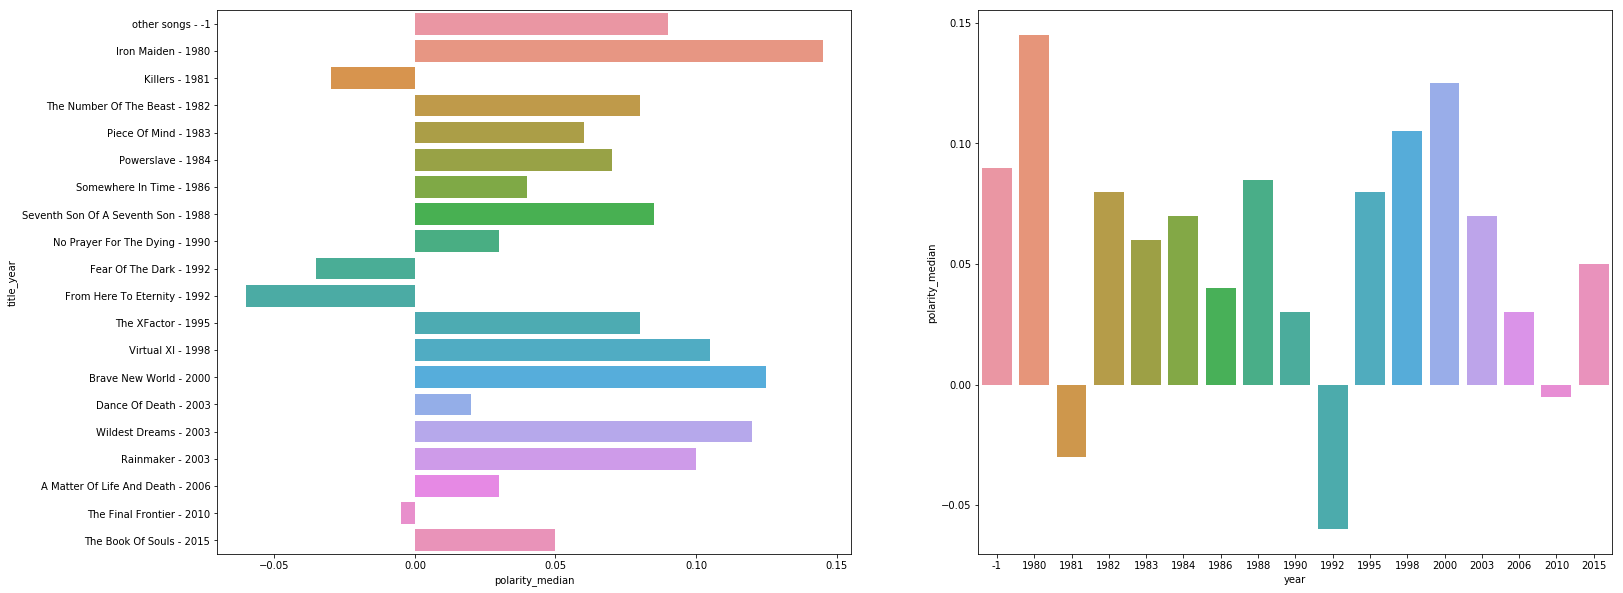

In [263]:
cols = ["title", "year", "polarity"]
album_sentiment_df = discography_df[cols].groupby(by=["title", "year"], as_index=False).agg({'polarity': ['mean','median']})
album_sentiment_df.columns = ["title", "year", "polarity_mean", "polarity_median"]
album_sentiment_df["title_year"] = album_sentiment_df["title"] + " - " + album_sentiment_df["year"].astype(str)
album_sentiment_df.sort_values("year", ascending=True, inplace=True)

year_sentiment_df = discography_df[["year", "polarity"]].groupby("year", as_index=False).agg({'polarity':['mean', 'median']})
year_sentiment_df.columns = ["year", "polarity_mean", "polarity_median"]
year_sentiment_df.sort_values("year", ascending=True, inplace=True)

f, ax = plt.subplots(1,2,figsize=(25,10))
g = sns.barplot(y="title_year", x="polarity_median", data=album_sentiment_df, ax=ax[0])
g = sns.barplot(x="year", y="polarity_median", data=year_sentiment_df, ax=ax[1])

**Observations**

1. Albums as a whole seem to be predominantly positive and uplifting. 
1. The most negative album was released on the year I was born... (*Fear of the dark*)

----------

# Album level analysis

Combine the songs for each album

In [126]:
q = "(is_single==False)"
album_df = discography_df.query(q)[["title", "year"]]
album_df["lyrics"] = discography_df.query(q).groupby(["title", "year"])['lyrics_cleaned'].transform(lambda x: ' '.join(x))
album_df.drop_duplicates(inplace=True)
album_df

,title,year,lyrics
0,Iron Maiden,1980,walking through the city looking oh so pretty i ve just got to find my way see the ladies flash...
8,Killers,1981,i was born into a scene of angriness and greed and dominance and persecution my mother was a q...
17,The Number Of The Beast,1982,longboats have been sighted the evidence of war has begun many nordic fighting men their swords ...
26,Piece Of Mind,1983,it s snowing outside the rumbling sound of engines roar in the night the mission is near the co...
35,Powerslave,1984,there goes the siren that warns of the air raid then comes the sound of the guns sending flak ou...
42,Somewhere In Time,1986,if you had the time to lose an open mind and time to choose would you care to take a look or can...
50,Seventh Son Of A Seventh Son,1988,seven deadly sins seven ways to win seven holy paths to hell and your trip begins seven downwar...
58,No Prayer For The Dying,1990,trace your way back years to the glow of dresden blood and tears in the black above by the ...
68,Fear Of The Dark,1992,covered in sinners and dripping with guilt making your money from slime and from filth parading ...
85,The XFactor,1995,eleven saintly shrouded men silhouettes stand against the sky one in front with a cross held hig...


### WordClouds 

In [127]:
from wordcloud import WordCloud
from sklearn.feature_extraction import text 


wc = WordCloud(stopwords=text.ENGLISH_STOP_WORDS, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

In [128]:
album_df.reset_index(drop=True, inplace=True)
# album_df

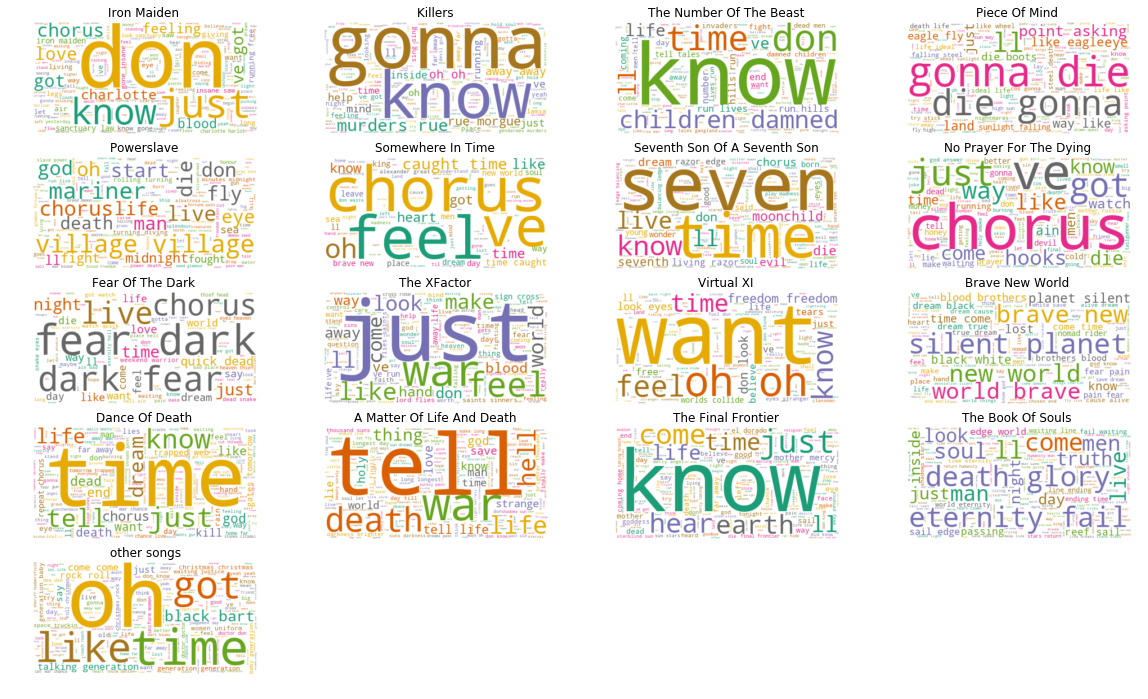

In [129]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 12]

albums = album_df["title"]

# Create subplots for each album
for idx, album in zip(album_df.index, albums):
    q = "title==\""+album+"\""
    wc.generate(album_df.query(q)["lyrics"].values[0])
    
    plt.subplot(5, 4, idx+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(album)
    
plt.show()

We definitely need to adminisiter more cleaning and remove some of the irrelevant words

Let's get a list of the most common words in each album

### Tokenize  

In [130]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(album_df["lyrics"])

In [131]:
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = album_df["title"]
data_dtm.head()

,abandoned,abates,abide,ablaze,able,aboard,absolution,abuse,abused,abyss,acacia,accept,accompany,according,accursed,...,yearning,years,yeeeeaaaaaaaahhhh,yellow,yes,yesterday,yield,yoke,yorkshire,young,youth,yowsa,zeal,zero,zone
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Iron Maiden,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0
Killers,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1
The Number Of The Beast,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Piece Of Mind,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0
Powerslave,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [132]:
data_dtm.index

Index(['Iron Maiden ', 'Killers ', 'The Number Of The Beast ', 'Piece Of Mind ', 'Powerslave ',
       'Somewhere In Time ', 'Seventh Son Of A Seventh Son ', 'No Prayer For The Dying ',
       'Fear Of The Dark ', 'The XFactor ', 'Virtual XI ', 'Brave New World ', 'Dance Of Death ',
       'A Matter Of Life And Death ', 'The Final Frontier ', 'The Book Of Souls ', 'other songs'],
      dtype='object', name='title')

In [133]:
data_dtm_t = data_dtm.transpose()
# for alb in data_dtm.index:
#     print(data_dtm_t[alb].sort_values(ascending=False)[:10])

### LDA topic modeling

In [134]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
 
NUM_TOPICS = 3
 
# Make the vectorizer and vectorize the data
vectorizer = CountVectorizer(min_df=0.1,  # if a word exists in less than 30 documents, ignore them
                             max_df=0.8,  # Avoid words that come in over 80% of all documents
                             stop_words='english', 
                             lowercase=True, 
                             token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(album_df["lyrics"])
 
# Build a Latent Dirichlet Allocation Model
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, 
                                      max_iter=10,
                                      learning_method='online')
lda_Z = lda_model.fit_transform(data_vectorized)

In [135]:
import os
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [136]:
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
# panel

---------

In [137]:
album_df.head()

,title,year,lyrics
0,Iron Maiden,1980,walking through the city looking oh so pretty i ve just got to find my way see the ladies flash...
1,Killers,1981,i was born into a scene of angriness and greed and dominance and persecution my mother was a q...
2,The Number Of The Beast,1982,longboats have been sighted the evidence of war has begun many nordic fighting men their swords ...
3,Piece Of Mind,1983,it s snowing outside the rumbling sound of engines roar in the night the mission is near the co...
4,Powerslave,1984,there goes the siren that warns of the air raid then comes the sound of the guns sending flak ou...


### Sentiment Analysis

Input of a sentiment analysis model should be a **corpus**.

We will use a tool called _textblob_, which is built on top of nltk.
_textblob_ finds all the words and phrases that it can assign a polarity and subjectivity score to, and averages all of them together.

Output of this analysis will be a sentiment score for each album by analysing the lyrics of the album.

#### Inter-album sentiment analysis

Let's find the polarity and subjectivity score of all the songs combined within each album

In [162]:
sen_pol = lambda x: (np.round(TextBlob(x).sentiment.polarity,2), 
                     np.round(TextBlob(x).sentiment.subjectivity))
album_df["polarity_subjectivity"] = album_df["lyrics"].apply(func=sen_pol)
album_df["polarity"] = album_df["polarity_subjectivity"].apply(lambda x: x[0])
album_df["subjectivity"] = album_df["polarity_subjectivity"].apply(lambda x: x[1])
album_df.drop("polarity_subjectivity", axis=1, inplace=True)
album_df.head()

,title,year,lyrics,polarity,subjectivity
0,Iron Maiden,1980,walking through the city looking oh so pretty i ve just got to find my way see the ladies flash...,0.09,0.0
1,Killers,1981,i was born into a scene of angriness and greed and dominance and persecution my mother was a q...,-0.00,1.0
2,The Number Of The Beast,1982,longboats have been sighted the evidence of war has begun many nordic fighting men their swords ...,0.07,0.0
3,Piece Of Mind,1983,it s snowing outside the rumbling sound of engines roar in the night the mission is near the co...,0.18,1.0
4,Powerslave,1984,there goes the siren that warns of the air raid then comes the sound of the guns sending flak ou...,0.07,0.0


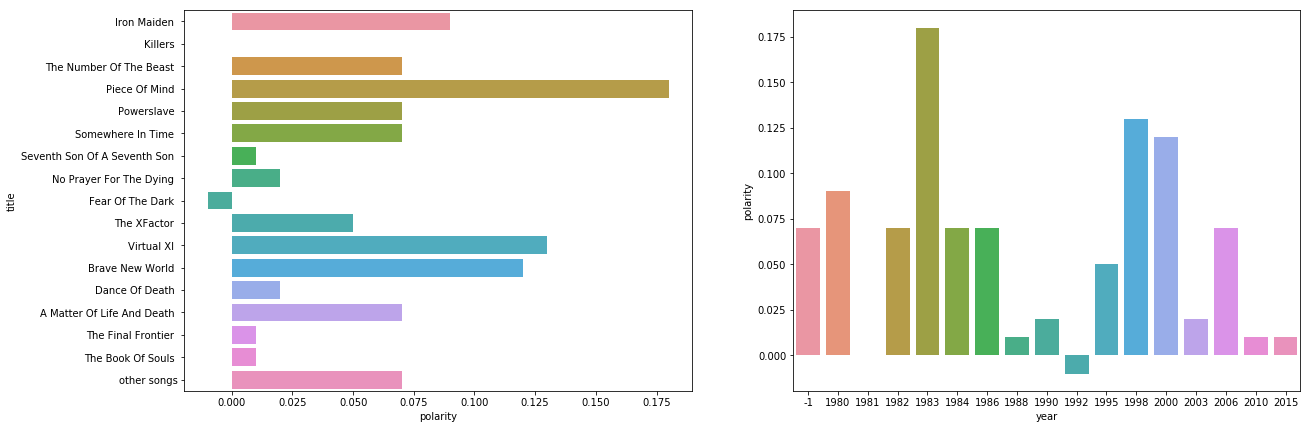

In [168]:
f, ax = plt.subplots(1,2,figsize=(20,7))
g = sns.barplot(y="title", x="polarity", data=album_df, ax=ax[0])
g = sns.barplot(x="year", y="polarity", data=album_df, ax=ax[1])

---------

---------

---------

---------

In [14]:
# dtm_filename = "iron_maiden_dtm.pkl"
# save_to_disk(data_dtm, dtm_filename)

----------------

In [15]:
# data = load_from_disk(dtm_filename)
# data.shape